<a href="https://colab.research.google.com/github/sacrafont/connection/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

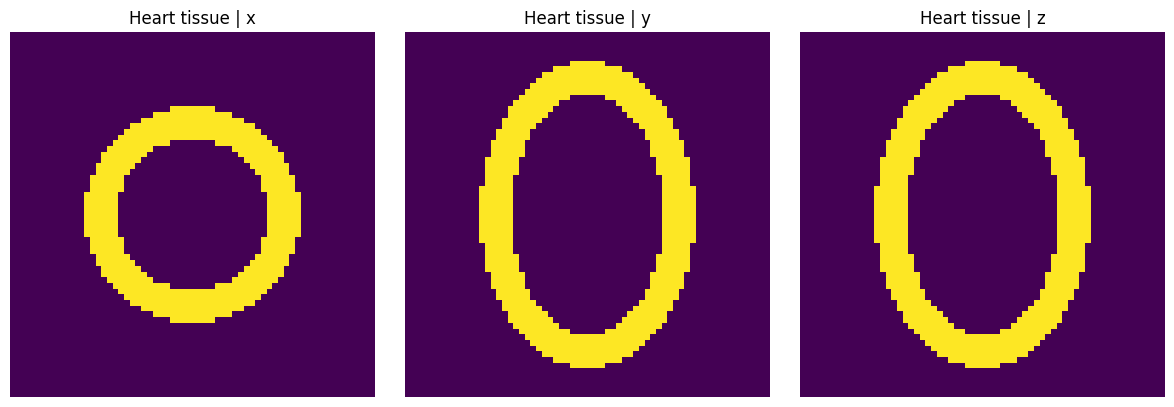

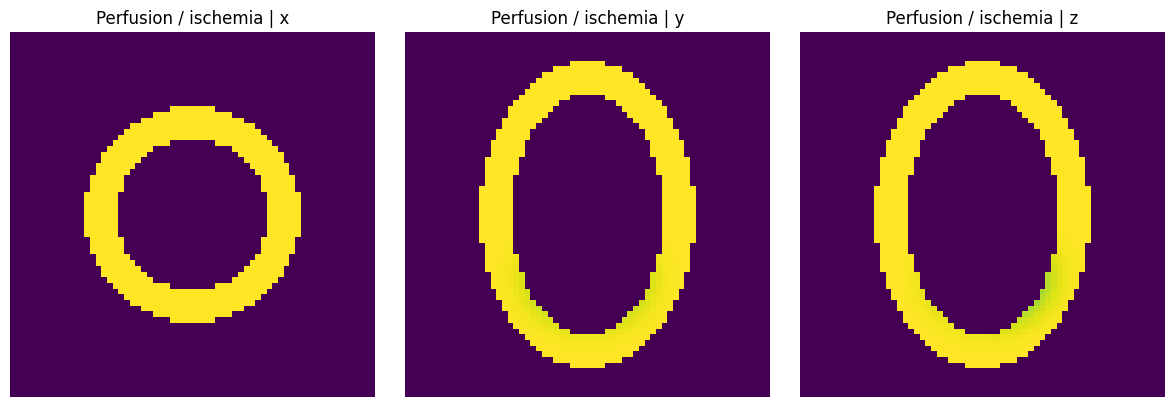

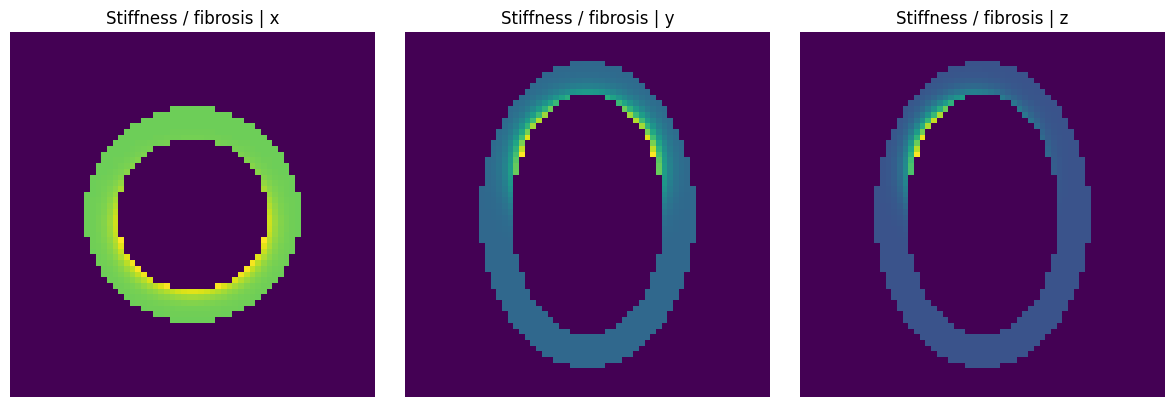

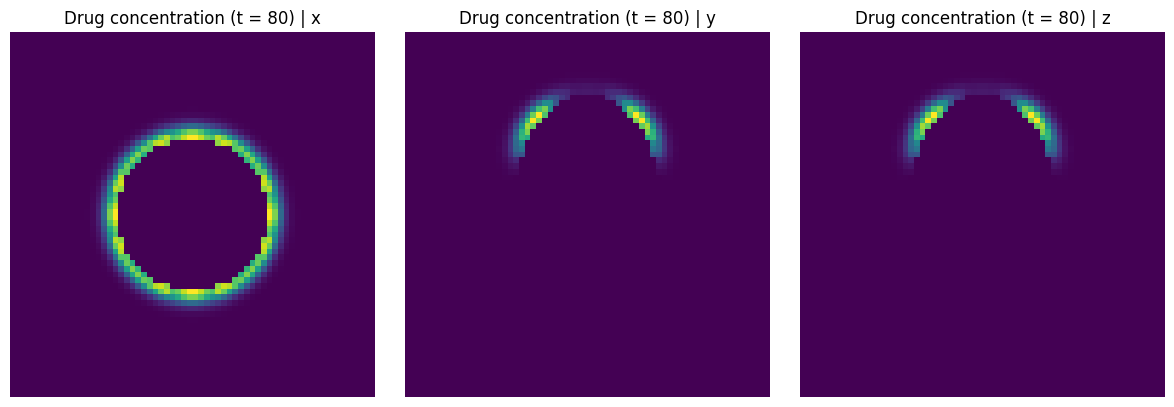

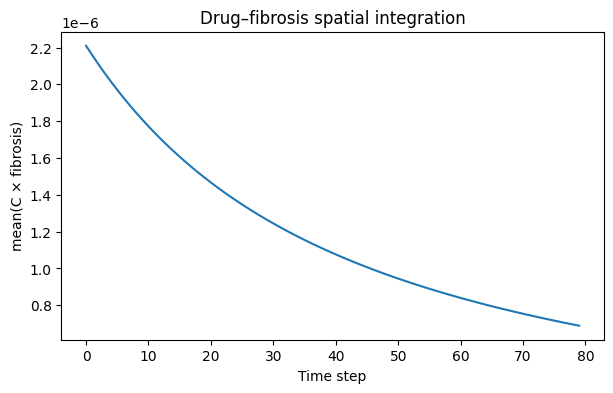

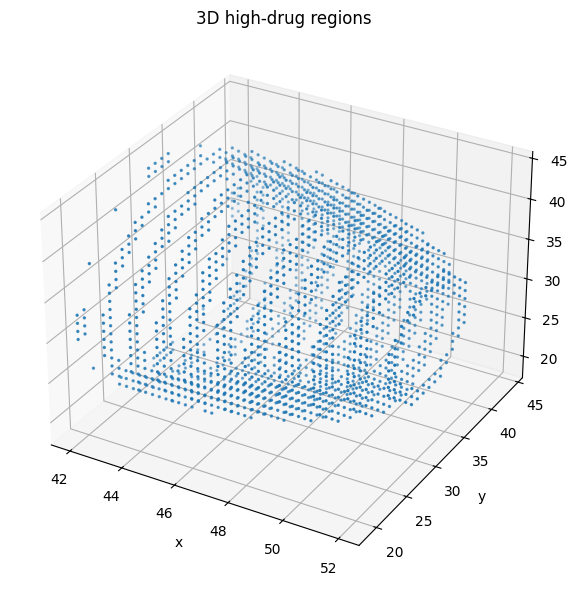

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 64

rx, ry, rz = 0.85, 0.60, 0.60
wall = 0.18

isc_center = (-0.35, 0.05, 0.00)
isc_sigma  = (0.18, 0.22, 0.22)

fib_center = (0.25, -0.05, 0.00)
fib_sigma  = (0.20, 0.18, 0.20)

inj_center = (0.35, 0.00, 0.00)
inj_sigma  = (0.10, 0.12, 0.12)

D = 0.12
k_deg = 0.01
T = 80
dt = 0.08

x = np.linspace(-1, 1, N)
X, Y, Z = np.meshgrid(x, x, x, indexing="ij")

def gaussian_3d(center, sigma):
    cx, cy, cz = center
    sx, sy, sz = sigma
    return np.exp(
        -(((X-cx)**2)/(sx**2) +
          ((Y-cy)**2)/(sy**2) +
          ((Z-cz)**2)/(sz**2))
    )

outer = ((X/rx)**2 + (Y/ry)**2 + (Z/rz)**2) <= 1.0
inner = ((X/(rx-wall))**2 + (Y/(ry-wall))**2 + (Z/(rz-wall))**2) <= 1.0
tissue = (outer & (~inner)).astype(np.float32)

mask = tissue.astype(bool)

ischemia = gaussian_3d(isc_center, isc_sigma) * tissue
perfusion = (1.0 - 0.85 * ischemia) * tissue
perfusion = np.clip(perfusion, 0, 1)

fibrosis = gaussian_3d(fib_center, fib_sigma) * tissue
fibrosis /= (fibrosis.max() + 1e-9)

stiffness = (0.25 + 0.85 * fibrosis) * tissue
stiffness = np.clip(stiffness, 0, 1)

C = (gaussian_3d(inj_center, inj_sigma) * tissue).astype(np.float32)

def laplacian_3d(u):
    u_pad = np.pad(u, 1, mode="edge")
    return (
        u_pad[2:,1:-1,1:-1] + u_pad[:-2,1:-1,1:-1] +
        u_pad[1:-1,2:,1:-1] + u_pad[1:-1,:-2,1:-1] +
        u_pad[1:-1,1:-1,2:] + u_pad[1:-1,1:-1,:-2] -
        6.0 * u_pad[1:-1,1:-1,1:-1]
    )

overlap_trace = []

for _ in range(T):
    C += dt * (D * laplacian_3d(C) - k_deg * C) * tissue
    C = np.clip(C, 0, None)
    overlap_trace.append(float((C[mask] * fibrosis[mask]).mean()))

def show_slices(volume, title):
    k = N // 2
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(volume[k,:,:], origin="lower"); ax[0].set_title(title + " | x"); ax[0].axis("off")
    ax[1].imshow(volume[:,k,:], origin="lower"); ax[1].set_title(title + " | y"); ax[1].axis("off")
    ax[2].imshow(volume[:,:,k], origin="lower"); ax[2].set_title(title + " | z"); ax[2].axis("off")
    plt.tight_layout()
    plt.show()

show_slices(tissue, "Heart tissue")
show_slices(perfusion, "Perfusion / ischemia")
show_slices(stiffness, "Stiffness / fibrosis")
show_slices(C, f"Drug concentration (t = {T})")

plt.figure(figsize=(7,4))
plt.plot(overlap_trace)
plt.xlabel("Time step")
plt.ylabel("mean(C × fibrosis)")
plt.title("Drug–fibrosis spatial integration")
plt.show()

threshold = np.percentile(C[mask], 92)
points = np.argwhere((C > threshold) & (tissue > 0))

if len(points) > 6000:
    points = points[np.random.choice(len(points), 6000, replace=False)]

if len(points) > 0:
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:,0], points[:,1], points[:,2], s=2)
    ax.set_title("3D high-drug regions")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    plt.tight_layout()
    plt.show()
else:
    print("No high-drug voxels detected.")
